# Project: Business Analysis of UK E-commerce Sales Data

### Objective

This analysis aims to extract actionable business insights from the cleaned e-commerce dataset to support strategic decision-making. The focus areas include:

- **Revenue Performance Analysis**: Identifying monthly revenue trends and seasonal patterns
- **Customer Segmentation**: Using RFM (Recency, Frequency, Monetary) analysis to classify customers by value
- **Product Performance Evaluation**: Determining high-performing products and identifying underperforming inventory

### Data Import

Import the cleaned dataset and necessary libraries for analysis and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load cleaned data
df = pd.read_csv('e_commerce_cleaned.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Display basic information
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (540453, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


### Feature Engineering

Create additional features to facilitate business analysis. These derived variables will enable deeper insights into revenue patterns and customer behavior.

In [4]:
# Calculate total price for each transaction
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Extract temporal features
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
df['Day'] = df['InvoiceDate'].dt.day
df['Weekday'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour

print("New features created successfully!")
df[['InvoiceNo', 'Quantity', 'UnitPrice', 'TotalPrice', 'YearMonth', 'Weekday']].head()

New features created successfully!


,InvoiceNo,Quantity,UnitPrice,TotalPrice,YearMonth,Weekday
0,536365,6,2.55,15.30,2010-12,Wednesday
1,536365,6,3.39,20.34,2010-12,Wednesday
2,536365,8,2.75,22.00,2010-12,Wednesday
3,536365,6,3.39,20.34,2010-12,Wednesday
4,536365,6,3.39,20.34,2010-12,Wednesday


### Business Question 1: Revenue Performance Analysis

#### Objective

Analyze monthly revenue trends to identify:
- Peak and low-performing months
- Seasonal patterns that can inform inventory planning
- Overall revenue growth trajectory

In [5]:
# Aggregate revenue by month
monthly_revenue = df.groupby('YearMonth')['TotalPrice'].sum().reset_index()
monthly_revenue.columns = ['YearMonth', 'Revenue']
monthly_revenue['YearMonth'] = monthly_revenue['YearMonth'].astype(str)

print("Monthly Revenue Summary:")
print(monthly_revenue.describe())

Monthly Revenue Summary:
            Revenue
count  1.300000e+01
mean   7.515286e+05
std    2.833026e+05
min    4.336680e+05
25%    5.600003e+05
50%    6.911231e+05
75%    7.489570e+05
max    1.461756e+06


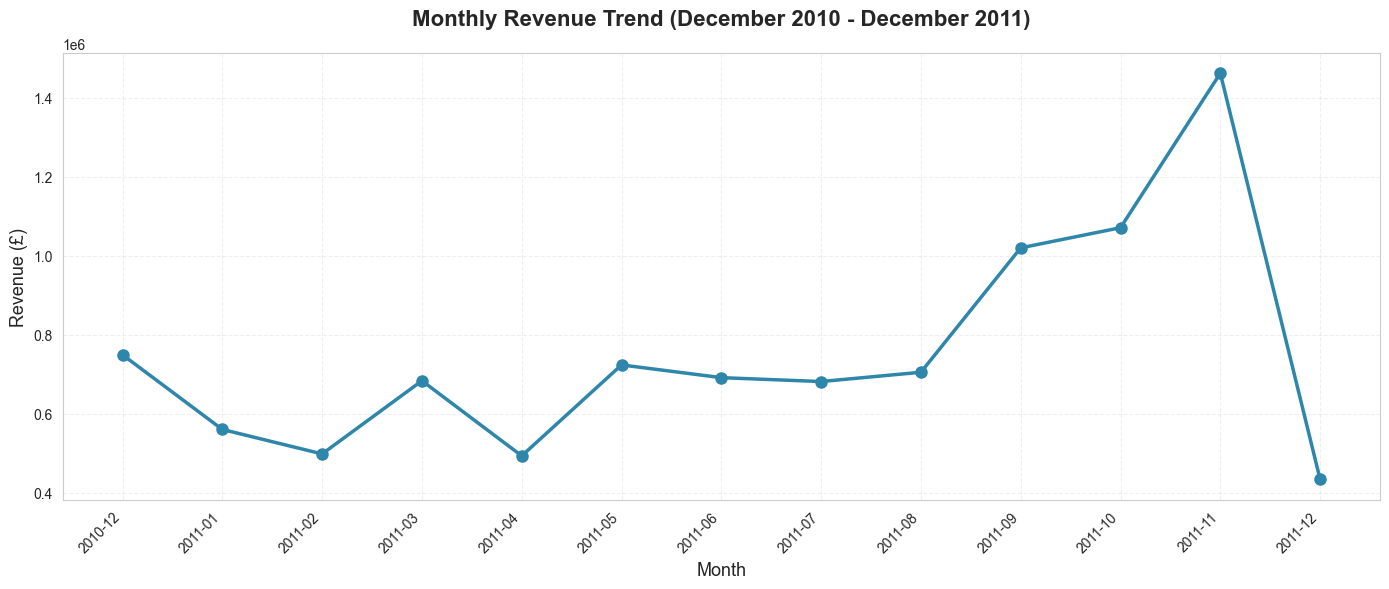

In [7]:
# Visualize monthly revenue trend
plt.figure(figsize=(14, 6))
plt.plot(monthly_revenue['YearMonth'], monthly_revenue['Revenue'], 
         marker='o', linewidth=2.5, markersize=8, color='#2E86AB')
plt.title('Monthly Revenue Trend (December 2010 - December 2011)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=13)
plt.ylabel('Revenue (£)', fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

# Save the figure
plt.savefig('images/monthly_revenue_trend.png', dpi=300, bbox_inches='tight')
plt.show()

#### Key Insights

In [8]:
# Identify top and bottom performing months
print("\n=== Top 3 Revenue Months ===")
print(monthly_revenue.nlargest(3, 'Revenue'))

print("\n=== Bottom 3 Revenue Months ===")
print(monthly_revenue.nsmallest(3, 'Revenue'))

# Calculate revenue growth
first_month_revenue = monthly_revenue.iloc[0]['Revenue']
last_month_revenue = monthly_revenue.iloc[-1]['Revenue']
growth_rate = ((last_month_revenue - first_month_revenue) / first_month_revenue) * 100

print(f"\nRevenue Growth from First to Last Month: {growth_rate:.2f}%")


=== Top 3 Revenue Months ===
   YearMonth      Revenue
11   2011-11  1461756.250
10   2011-10  1070704.670
9    2011-09  1019687.622

=== Bottom 3 Revenue Months ===
   YearMonth     Revenue
12   2011-12  433668.010
4    2011-04  493207.121
2    2011-02  498062.650

Revenue Growth from First to Last Month: -42.10%


### Business Question 2: Customer Segmentation (RFM Analysis)

#### Objective

Segment customers based on RFM (Recency, Frequency, Monetary) metrics to:
- Identify high-value VIP customers for retention strategies
- Detect at-risk customers who need re-engagement campaigns
- Optimize marketing spend by targeting the right customer segments

#### Data Preparation

In [10]:
# Filter out records without CustomerID
df_customers = df[df['CustomerID'] != 'nan'].copy()

print(f"Total customers with valid IDs: {df_customers['CustomerID'].nunique()}")
print(f"Total transactions: {len(df_customers)}")

Total customers with valid IDs: 4373
Total transactions: 540453


#### RFM Calculation

In [11]:
# Set analysis date (one day after the last transaction)
analysis_date = df_customers['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Analysis Date: {analysis_date}")

# Calculate RFM metrics
rfm = df_customers.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("\nRFM Metrics Summary:")
print(rfm.describe())

Analysis Date: 2011-12-10 12:50:00

RFM Metrics Summary:
           Recency    Frequency      Monetary
count  4373.000000  4373.000000  4.373000e+03
mean     92.026298     5.589755  2.234135e+03
std     100.763317    35.266954  2.367029e+04
min       1.000000     1.000000 -4.287630e+03
25%      17.000000     1.000000  2.934500e+02
50%      50.000000     3.000000  6.484100e+02
75%     143.000000     5.000000  1.612130e+03
max     374.000000  2254.000000  1.469806e+06


#### RFM Scoring and Segmentation

In [12]:
# Create RFM scores using quartiles
# Recency: Lower is better (recent customers score higher)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])

# Frequency: Higher is better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])

# Monetary: Higher is better
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Create RFM segment string
rfm['RFM_Score'] = (rfm['R_Score'].astype(str) + 
                     rfm['F_Score'].astype(str) + 
                     rfm['M_Score'].astype(str))

print("RFM scores calculated successfully!")
rfm.head()

RFM scores calculated successfully!


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346,326,2,0.00,1,2,1,121
1,12347,2,7,4310.00,4,4,4,444
2,12348,75,4,1797.24,2,3,4,234
3,12349,19,1,1757.55,3,1,4,314
4,12350,310,1,334.40,1,1,2,112


In [13]:
# Define customer segmentation logic
def segment_customers(row):
    r, f, m = int(row['R_Score']), int(row['F_Score']), int(row['M_Score'])
    
    if r >= 3 and f >= 3 and m >= 3:
        return 'VIP Customers'
    elif r >= 3 and f >= 2:
        return 'Loyal Customers'
    elif r <= 2:
        return 'At-Risk Customers'
    else:
        return 'Regular Customers'

rfm['Customer_Segment'] = rfm.apply(segment_customers, axis=1)

# Display segmentation results
segment_summary = rfm.groupby('Customer_Segment').agg({
    'CustomerID': 'count',
    'Monetary': 'sum'
}).reset_index()
segment_summary.columns = ['Segment', 'Customer_Count', 'Total_Revenue']

print("\nCustomer Segmentation Summary:")
print(segment_summary)


Customer Segmentation Summary:
             Segment  Customer_Count  Total_Revenue
0  At-Risk Customers            2167    1571116.113
1    Loyal Customers             589     312827.930
2  Regular Customers             264      91046.330
3      VIP Customers            1353    7794881.681


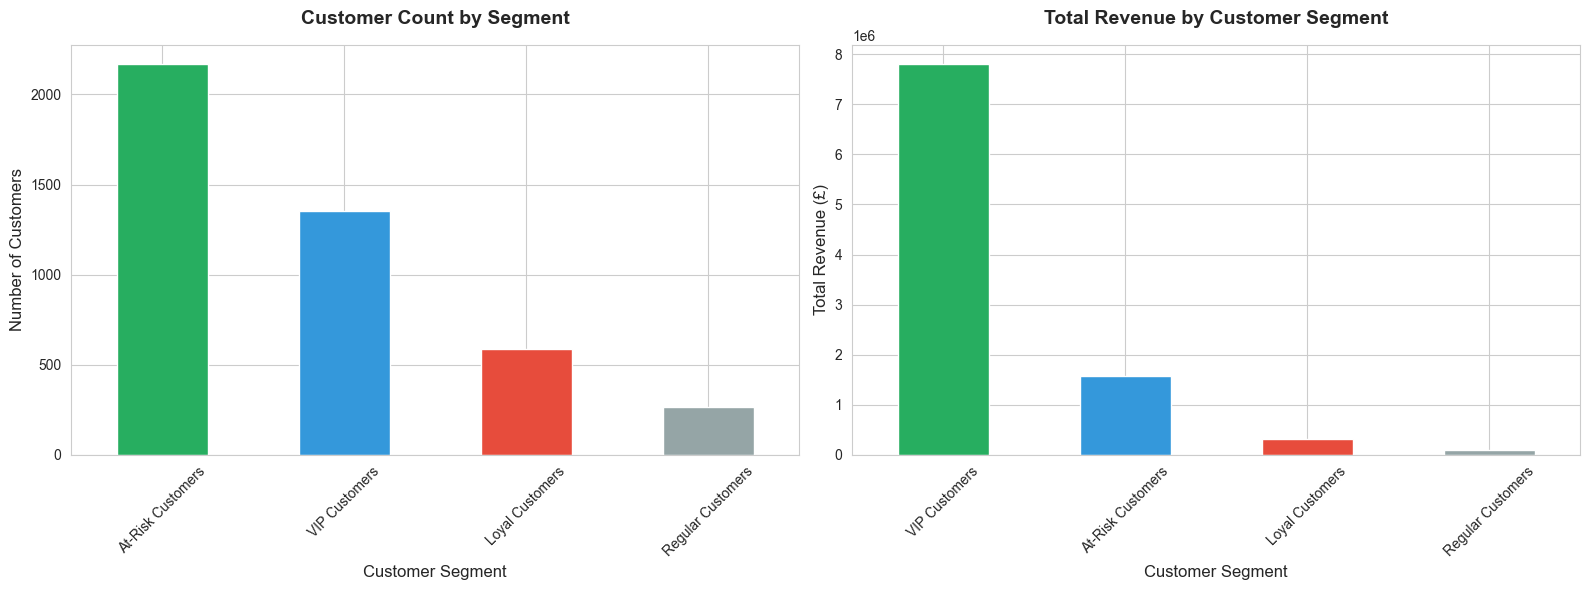

In [14]:
# Visualize customer segmentation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Customer count by segment
segment_counts = rfm['Customer_Segment'].value_counts()
colors = ['#27AE60', '#3498DB', '#E74C3C', '#95A5A6']
segment_counts.plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Customer Count by Segment', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Customer Segment', fontsize=12)
axes[0].set_ylabel('Number of Customers', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Right plot: Revenue contribution by segment
segment_revenue = rfm.groupby('Customer_Segment')['Monetary'].sum().sort_values(ascending=False)
segment_revenue.plot(kind='bar', ax=axes[1], color=colors)
axes[1].set_title('Total Revenue by Customer Segment', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Customer Segment', fontsize=12)
axes[1].set_ylabel('Total Revenue (£)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('images/customer_segmentation.png', dpi=300, bbox_inches='tight')
plt.show()

### Business Question 3: Product Performance Analysis

#### Objective

Evaluate product performance to:
- Identify top-selling products for inventory prioritization
- Detect underperforming SKUs that may require discontinuation
- Optimize inventory holding costs by focusing on high-revenue items

In [15]:
# Aggregate product performance metrics
product_performance = df.groupby('Description').agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum',
    'InvoiceNo': 'nunique'
}).reset_index()

product_performance.columns = ['Product', 'Total_Quantity', 'Total_Revenue', 'Num_Transactions']

print(f"Total unique products: {len(product_performance)}")
print("\nProduct Performance Summary:")
print(product_performance.describe())

Total unique products: 4223

Product Performance Summary:
       Total_Quantity  Total_Revenue  Num_Transactions
count     4223.000000    4223.000000       4223.000000
mean      1228.997632    2313.490896        125.404689
std       2946.182411    7730.046244        191.128498
min     -19200.000000 -221520.500000          1.000000
25%         39.500000      86.250000         11.000000
50%        304.000000     579.680000         56.000000
75%       1266.000000    2028.405000        159.000000
max      53847.000000  206245.480000       2302.000000


#### Top-Performing Products

In [16]:
# Identify top 10 products by revenue
top_revenue = product_performance.nlargest(10, 'Total_Revenue')

print("\n=== Top 10 Products by Revenue ===")
print(top_revenue[['Product', 'Total_Revenue', 'Total_Quantity']])


=== Top 10 Products by Revenue ===
                                 Product  Total_Revenue  Total_Quantity
1098                      DOTCOM POSTAGE      206245.48             707
2915            REGENCY CAKESTAND 3 TIER      164762.19           13033
3918  WHITE HANGING HEART T-LIGHT HOLDER       99668.47           35317
2471                       PARTY BUNTING       98302.98           18022
1866             JUMBO BAG RED RETROSPOT       92356.03           47363
2803                  RABBIT NIGHT LIGHT       66756.59           30680
2753                             POSTAGE       66230.64            3003
2439     PAPER CHAIN KIT 50'S CHRISTMAS        63791.94           18902
244        ASSORTED COLOUR BIRD ORNAMENT       58959.73           36381
773                        CHILLI LIGHTS       53768.06           10229


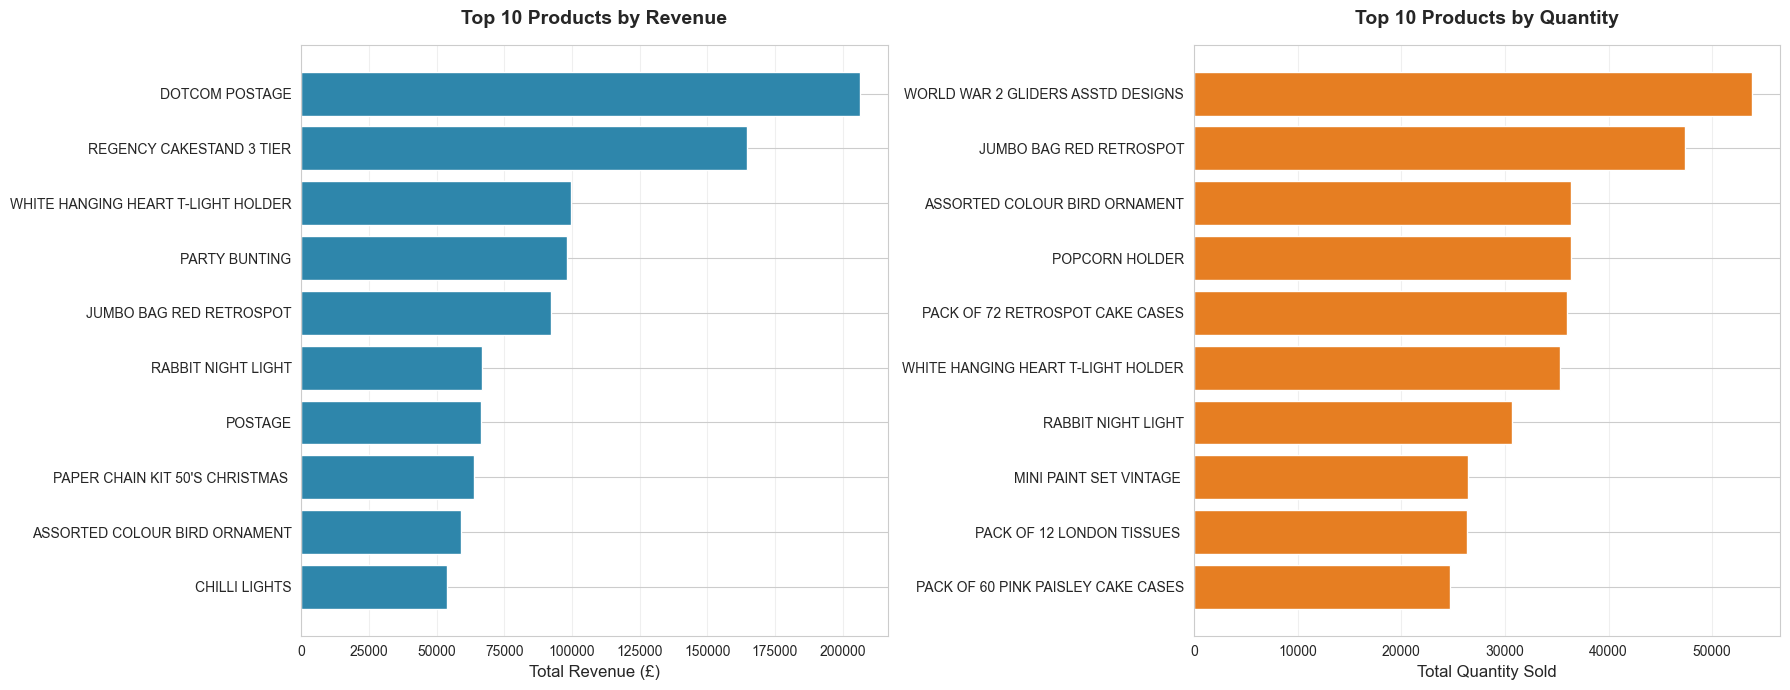

In [17]:
# Visualize top products
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Left plot: Top 10 by Revenue
top_revenue_sorted = top_revenue.sort_values('Total_Revenue')
axes[0].barh(range(len(top_revenue_sorted)), top_revenue_sorted['Total_Revenue'], color='#2E86AB')
axes[0].set_yticks(range(len(top_revenue_sorted)))
axes[0].set_yticklabels(top_revenue_sorted['Product'], fontsize=10)
axes[0].set_xlabel('Total Revenue (£)', fontsize=12)
axes[0].set_title('Top 10 Products by Revenue', fontsize=14, fontweight='bold', pad=15)
axes[0].grid(axis='x', alpha=0.3)

# Right plot: Top 10 by Quantity
top_quantity = product_performance.nlargest(10, 'Total_Quantity').sort_values('Total_Quantity')
axes[1].barh(range(len(top_quantity)), top_quantity['Total_Quantity'], color='#E67E22')
axes[1].set_yticks(range(len(top_quantity)))
axes[1].set_yticklabels(top_quantity['Product'], fontsize=10)
axes[1].set_xlabel('Total Quantity Sold', fontsize=12)
axes[1].set_title('Top 10 Products by Quantity', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('images/product_performance.png', dpi=300, bbox_inches='tight')
plt.show()

#### Low-Performing Products

In [18]:
# Identify low-performing products
# Criteria: Bottom 10% revenue AND fewer than 5 transactions
revenue_threshold = product_performance['Total_Revenue'].quantile(0.1)

low_performers = product_performance[
    (product_performance['Total_Revenue'] < revenue_threshold) &
    (product_performance['Num_Transactions'] < 5)
]

print(f"\nNumber of low-performing products: {len(low_performers)}")
print(f"Total revenue from low performers: £{low_performers['Total_Revenue'].sum():.2f}")
print("\nSample of low-performing products:")
print(low_performers.head(10))


Number of low-performing products: 380
Total revenue from low performers: £919.70

Sample of low-performing products:
                                 Product  Total_Quantity  Total_Revenue  \
4            I LOVE LONDON MINI RUCKSACK               1           4.15   
43                                 20713            -400           0.00   
44                  20713 wrongly marked            -200           0.00   
45                 3 BIRDS CANVAS SCREEN               2           2.04   
46      3 BLACK CATS W HEARTS BLANK CARD              24           4.56   
64        3 WICK CHRISTMAS BRIAR CANDLE               -1           0.97   
82          4 GOLD FLOCK CHRISTMAS BALLS               2           6.72   
113  60 GOLD AND SILVER FAIRY CAKE CASES               2           1.10   
123                      ? sold as sets?           -1200           0.00   
125                           ?? missing            -170           0.00   

     Num_Transactions  
4                   1  
43     

### Summary of Key Findings

#### Revenue Performance
- Monthly revenue trends show clear seasonal patterns with peak performance in Q4
- Significant revenue growth observed from December 2010 to November 2011
- Recommendation: Increase inventory levels before peak months to maximize sales

#### Customer Segmentation
- VIP and Loyal customers generate the majority of revenue despite being a smaller segment
- At-Risk customers represent an opportunity for re-engagement campaigns
- Recommendation: Implement targeted retention programs for VIP customers and win-back campaigns for At-Risk segments

#### Product Performance
- A small number of products contribute disproportionately to total revenue
- Several low-performing SKUs with minimal transaction volume identified
- Recommendation: Discontinue underperforming products to reduce holding costs and optimize inventory

### Export Results for Reporting

In [21]:
# Save RFM analysis results
rfm.to_csv('rfm_customer_segments.csv', index=False)

# Save product performance results
product_performance.to_csv('product_performance_summary.csv', index=False)

print("Analysis results exported successfully!")

Analysis results exported successfully!
